# Chapter 10

## Building an Image Classifier Using the Sequential API

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.tensorboard import SummaryWriter

In [2]:
root_dir = 'data'
full_train_dset = FashionMNIST(root=root_dir,
                               train=True,
                               download=True,
                               transform=ToTensor())
test_dset = FashionMNIST(root=root_dir,
                         train=False,
                         download=True,
                         transform=ToTensor())

In [3]:
device = 'cuda'
if torch.cuda.device_count() == 2:
    torch.cuda.set_device(1)

In [4]:
train_dset = Subset(full_train_dset, indices=range(55000))
valid_dset = Subset(full_train_dset, indices=range(55000, 60000))

In [5]:
len(train_dset), len(valid_dset)

(55000, 5000)

In [6]:
batch_size = 32 # Default batch size on keras

In [7]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

## Normalization

In Geron's book the data are normalized by dividing by 255. The `ToTensor()` transform added to the Dataset definition takes care of this automatically.

In [8]:
img, tgt = next(iter(valid_loader))

In [9]:
img.max()

tensor(1.)

In [10]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [11]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=10))
    
    def forward(self, x):
        return self.sequential_model(x)

In [12]:
classif_model = MyModel()
classif_model

MyModel(
  (sequential_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [13]:
classif_model.sequential_model[1].bias[0]

tensor(0.0097, grad_fn=<SelectBackward0>)

In [14]:
classif_model.sequential_model[1].weight[0, :10]

tensor([-0.0194,  0.0207,  0.0205, -0.0123, -0.0234,  0.0215,  0.0184, -0.0249,
         0.0315, -0.0067], grad_fn=<SliceBackward0>)

## Weight initialization

In Keras weights in a dense layer are, [by default](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), initialized with a Glorot Uniform initialization.

In Pytorch weights in a linear layer are, [by default](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) initialized with a uniform distribution with  U(−k,k) where k=1/in_features. This is essentially a LeCun uniform initialization. Note that in PyTorch, Glorot initialization is called Xavier initialization.

In [15]:
@torch.no_grad()
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)

In [16]:
classif_model.apply(init_weights)

MyModel(
  (sequential_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [17]:
classif_model.sequential_model[1].bias[0]

tensor(0., grad_fn=<SelectBackward0>)

In [18]:
classif_model.sequential_model[1].weight[0, :10]

tensor([ 0.0380, -0.0405,  0.0061, -0.0318,  0.0638, -0.0513,  0.0744, -0.0589,
         0.0524,  0.0436], grad_fn=<SliceBackward0>)

Both the bias and the weight look different. We assume that we are using the same initialization approach as Keras.

The Keras model has a final softmax activation. If we use PyTorch cross-entropy loss, the softmax is fused in the loss, so we don't need to include it.

In [19]:
classif_model.to(device)

MyModel(
  (sequential_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [20]:
loss_fn = torch.nn.CrossEntropyLoss()

## Optimizers

The example in Geron's book uses the "sgd" optimizer, which I suspect corresponds to the [default settings](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/SGD), i.e., lr = 0.01 and momentum = 0.0.

In [21]:
classif_optim = optim.SGD(classif_model.parameters(), lr=0.01, momentum=0.0)

In [22]:
def train(dataloader, model, loss_fn, optimizer):
    num_obs = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        batch_loss = loss_fn(preds, y)
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 250 == 0:
            print(f'Train loss: {batch_loss.item():>.5}')

In [23]:
def validate(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    num_obs = len(dataloader.dataset)
    total_loss = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            total_loss += loss_fn(preds, y).item()
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()
    avg_batch_loss = total_loss / num_batches
    accuracy = correct / num_obs
    print('Validation:')
    print(f'\nAverage loss: {avg_batch_loss:>.5} - Accuracy: {accuracy:>.3}')
    return avg_batch_loss, accuracy

In [24]:
epochs = 30

In [25]:
test_loss, test_accuracy = [], []

for epoch in range(epochs):
    print(f'\n----- Epoch: {epoch+1} -----\n')
    train(train_loader, classif_model, loss_fn, classif_optim)
    loss, acc = validate(valid_loader, classif_model, loss_fn)
    test_loss.append(loss)
    test_accuracy.append(acc)


----- Epoch: 1 -----

Train loss: 2.2598
Train loss: 0.8287
Train loss: 0.87436
Train loss: 0.64119
Train loss: 0.65544
Train loss: 0.55431
Train loss: 0.72651
Validation:

Average loss: 0.53774 - Accuracy: 0.812

----- Epoch: 2 -----

Train loss: 0.45458
Train loss: 0.3924
Train loss: 0.43722
Train loss: 0.41766
Train loss: 0.57856
Train loss: 0.40585
Train loss: 0.4903
Validation:

Average loss: 0.4529 - Accuracy: 0.838

----- Epoch: 3 -----

Train loss: 0.50073
Train loss: 0.37522
Train loss: 0.33948
Train loss: 0.53763
Train loss: 0.62118
Train loss: 0.77319
Train loss: 0.50318
Validation:

Average loss: 0.43388 - Accuracy: 0.84

----- Epoch: 4 -----

Train loss: 0.28299
Train loss: 0.83093
Train loss: 0.27268
Train loss: 0.39683
Train loss: 0.27692
Train loss: 0.48836
Train loss: 0.47582
Validation:

Average loss: 0.40688 - Accuracy: 0.856

----- Epoch: 5 -----

Train loss: 0.14218
Train loss: 0.43433
Train loss: 0.50023
Train loss: 0.41341
Train loss: 0.57753
Train loss: 0.16595

This is very similar to the performance shown in Geron's book.

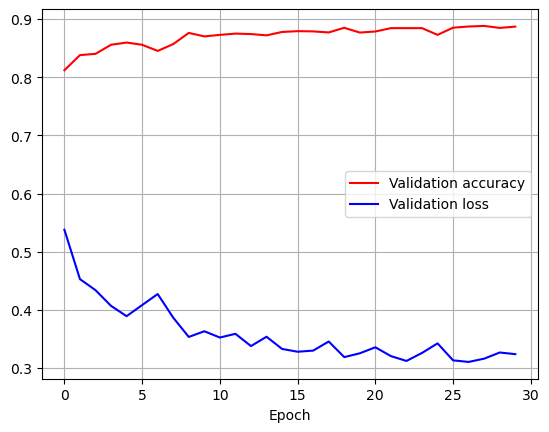

In [26]:
plt.plot(np.arange(30), test_accuracy, 'r-', label='Validation accuracy')
plt.plot(np.arange(30), test_loss, 'b-', label='Validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Performance on the test set

In [27]:
def get_test_performance(dataloader, model):
    test_accuracy = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            correct += (preds.argmax(1) == y).type(torch.float32).sum().item()
    return correct / len(dataloader.dataset)

In [28]:
get_test_performance(test_loader, classif_model)

0.8782

## Building a Regression MLP Using the Sequential API

For this example we use the California Housing dataset. After creating a training, validation, and test set, we must normalize the data and organize them into dataloaders.

**Note**: in HOML3 the loss is the mean squared error (MSE), but the metric is the root mean squared error (RMSE), therefore to go from the loss to the metric, you have to take the square root of the loss. Our loss and the loss in HOML3 should be directly comparable.

In [29]:
housing = fetch_california_housing()
x_train_full, x_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, y_train_full, random_state=42)

In [30]:
x_train.shape, x_valid.shape, x_test.shape

((11610, 8), (3870, 8), (5160, 8))

In [31]:
x_train[0]

array([ 3.52140000e+00,  1.50000000e+01,  3.04994451e+00,  1.10654828e+00,
        1.44700000e+03,  1.60599334e+00,  3.76300000e+01, -1.22430000e+02])

The data is clearly not normalized.

In [32]:
x_train.min(), x_train.max(), x_valid.min(), x_valid.max(), x_test.min(), x_test.max()

(-124.35, 16305.0, -124.27, 35682.0, -124.25, 16122.0)

In [33]:
means, std_devs = x_train.mean(axis=0), x_train.std(axis=0)
means.shape, std_devs.shape

((8,), (8,))

In [34]:
z_train = ((x_train - means) / std_devs).astype(np.float32)
z_valid = ((x_valid - means) / std_devs).astype(np.float32)
z_test = ((x_test - means) / std_devs).astype(np.float32)

In [35]:
z_test.dtype

dtype('float32')

In [36]:
z_train.mean(), z_train.std(), z_valid.mean(), z_valid.std(), z_test.mean(), z_test.std()

(2.4642746e-10, 1.0, 0.021390013, 3.6403675, -0.004968547, 0.99959093)

In [37]:
x_tensor_train = torch.FloatTensor(z_train)
y_tensor_train = torch.FloatTensor(y_train).unsqueeze(-1)
x_tensor_valid = torch.FloatTensor(z_valid)
y_tensor_valid = torch.FloatTensor(y_valid).unsqueeze(-1)
x_tensor_test = torch.FloatTensor(z_test)
y_tensor_test = torch.FloatTensor(y_test).unsqueeze(-1)

In [38]:
x_tensor_valid.mean(), x_tensor_valid.std()

(tensor(0.0214), tensor(3.6404))

In [39]:
train_dset = TensorDataset(x_tensor_train, y_tensor_train)
valid_dset = TensorDataset(x_tensor_valid, y_tensor_valid)
test_dset = TensorDataset(x_tensor_test, y_tensor_test)

In [40]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [41]:
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Linear(in_features=8, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=1))
    
    def forward(self, x):
        return self.sequential_model(x)

### Weight initialization

In [42]:
regression_model = RegressionModel()
regression_model.apply(init_weights)

RegressionModel(
  (sequential_model): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [43]:
regression_model = regression_model.to(device)

In [44]:
def train_regression(dataloader, model, loss_fn, optimizer):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        batch_loss = loss_fn(preds, y)
        total_loss += batch_loss.item()
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Train Loss: {total_loss/num_batches:>.5}")

In [45]:
def eval_regression(dataloader, model, loss_fn):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            total_loss += loss_fn(preds, y).item()
        print(f'Validation Loss: {total_loss/num_batches:>.5}')

In [46]:
loss_fn = nn.MSELoss()
regression_optim = optim.Adam(regression_model.parameters(), lr=1e-3, eps=1e-7)

In [47]:
for epoch in range(20):
    print(f'\n ----- Epoch {epoch+1} -----')
    train_regression(train_loader, regression_model, loss_fn, regression_optim)
    eval_regression(valid_loader, regression_model, loss_fn)


 ----- Epoch 1 -----
Train Loss: 0.81788
Validation Loss: 0.37046

 ----- Epoch 2 -----
Train Loss: 0.37564
Validation Loss: 0.38949

 ----- Epoch 3 -----
Train Loss: 0.34257
Validation Loss: 0.59244

 ----- Epoch 4 -----
Train Loss: 0.33984
Validation Loss: 1.1651

 ----- Epoch 5 -----
Train Loss: 0.32233
Validation Loss: 3.556

 ----- Epoch 6 -----
Train Loss: 0.33994
Validation Loss: 0.30953

 ----- Epoch 7 -----
Train Loss: 0.30563
Validation Loss: 1.527

 ----- Epoch 8 -----
Train Loss: 0.30651
Validation Loss: 1.0936

 ----- Epoch 9 -----
Train Loss: 0.29389
Validation Loss: 3.9415

 ----- Epoch 10 -----
Train Loss: 0.29799
Validation Loss: 1.1277

 ----- Epoch 11 -----
Train Loss: 0.31273
Validation Loss: 1.1509

 ----- Epoch 12 -----
Train Loss: 0.28833
Validation Loss: 0.27233

 ----- Epoch 13 -----
Train Loss: 0.28
Validation Loss: 0.28907

 ----- Epoch 14 -----
Train Loss: 0.27736
Validation Loss: 0.37452

 ----- Epoch 15 -----
Train Loss: 0.2728
Validation Loss: 0.27716

 

## Building Complex Models Using the Functional API

In [48]:
class WideAndDeep(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(in_features=8, out_features=30)
        self.relu = nn.ReLU()
        self.hidden_layer2 = nn.Linear(in_features=30, out_features=30)
        self.output_layer = nn.Linear(in_features=38, out_features=1)
    
    def forward(self, x):
        z = self.relu(self.hidden_layer1(x))
        z = self.relu(self.hidden_layer2(z))
        w = torch.cat((x, z), dim=-1)
        return self.output_layer(w)

In [49]:
widedeep = WideAndDeep()
widedeep.apply(init_weights)
widedeep = widedeep.to(device)

Note that we need to create another optimizer, as the existing one has been trained on a different architecture.

In [50]:
wnd_optim = optim.Adam(widedeep.parameters(), lr=1e-3, eps=1e-7)

In [51]:
for epoch in range(20):
    print(f'\n ----- Epoch {epoch+1} -----')
    train_regression(train_loader, widedeep, loss_fn, wnd_optim)
    eval_regression(valid_loader, widedeep, loss_fn)


 ----- Epoch 1 -----
Train Loss: 1.1853
Validation Loss: 0.67669

 ----- Epoch 2 -----
Train Loss: 0.44997
Validation Loss: 0.38968

 ----- Epoch 3 -----
Train Loss: 0.39356
Validation Loss: 0.35445

 ----- Epoch 4 -----
Train Loss: 0.36832
Validation Loss: 0.4875

 ----- Epoch 5 -----
Train Loss: 0.35712
Validation Loss: 0.35604

 ----- Epoch 6 -----
Train Loss: 0.34796
Validation Loss: 0.33302

 ----- Epoch 7 -----
Train Loss: 0.33967
Validation Loss: 0.42444

 ----- Epoch 8 -----
Train Loss: 0.33522
Validation Loss: 1.9243

 ----- Epoch 9 -----
Train Loss: 0.33862
Validation Loss: 3.0885

 ----- Epoch 10 -----
Train Loss: 0.3588
Validation Loss: 1.915

 ----- Epoch 11 -----
Train Loss: 0.3326
Validation Loss: 3.8271

 ----- Epoch 12 -----
Train Loss: 0.35038
Validation Loss: 1.4098

 ----- Epoch 13 -----
Train Loss: 0.32446
Validation Loss: 1.9612

 ----- Epoch 14 -----
Train Loss: 0.32261
Validation Loss: 1.2074

 ----- Epoch 15 -----
Train Loss: 0.32098
Validation Loss: 1.7509

 

### Sending inputs through two different paths

The next example HOML3 sends features 0 to 4 to the wide path and features 2 to 7 through the deep path as shown below:

![wide_deep](img/mls3_1015.png)

To make this work we need to:

1. Modify the Dataset so that it returns two inputs and one target.
2. Modify the model so that it has two inputs.

In this case, since there is only one output, the loss is unchanged. The source code for TensorDataset can be found [here](https://github.com/pytorch/pytorch/blob/03de15806e5d27ee4ef6d82dbcc66dac78f6e3bf/torch/utils/data/dataset.py#L193).

We just need to redefine `__getitem__()` and we don't need to touch `__init__()`. Our modified implementation returns a tuple containing a tuple of inputs and the output tensor.

In [52]:
class WideAndDeepDataset(TensorDataset):
    def __getitem__(self, index):
        x, y = self.tensors
        return (x[index, :5], x[index, 2:], y[index])

In [53]:
wnd_train_dset = WideAndDeepDataset(x_tensor_train, y_tensor_train)
wnd_valid_dset = WideAndDeepDataset(x_tensor_valid, y_tensor_valid)
wnd_test_dset = WideAndDeepDataset(x_tensor_test, y_tensor_test)

In [54]:
wnd_train_loader = DataLoader(wnd_train_dset, batch_size, shuffle=True)
wnd_valid_loader = DataLoader(wnd_valid_dset, batch_size, shuffle=False)
wnd_test_loader = DataLoader(wnd_test_dset, batch_size, shuffle=False)

In [55]:
class WideAndDeepTwoInputs(nn.Module):
    # x_wide contains 5 features. x_deep contains 6
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(in_features=6, out_features=30)
        self.relu = nn.ReLU()
        self.hidden_layer2 = nn.Linear(in_features=30, out_features=30)
        self.output_layer = nn.Linear(in_features=35, out_features=1)
    
    def forward(self, x_wide, x_deep):
        x_deep = self.relu(self.hidden_layer1(x_deep))
        x_deep = self.relu(self.hidden_layer2(x_deep))
        w = torch.cat((x_wide, x_deep), dim=-1)
        return self.output_layer(w)

In [56]:
model_two_inputs = WideAndDeepTwoInputs()
model_two_inputs.apply(init_weights)
model_two_inputs = model_two_inputs.to(device)

In [57]:
def train_two_inputs(dataloader, model, loss_fn, optimizer):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    for batch, (x_wide, x_deep, y) in enumerate(dataloader):
        x_wide, x_deep, y = x_wide.to(device), x_deep.to(device), y.to(device)
        preds = model(x_wide, x_deep)
        batch_loss = loss_fn(preds, y)
        total_loss += batch_loss.item()
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Train Loss: {total_loss/num_batches:>.5}")

In [58]:
def eval_two_inputs(dataloader, model, loss_fn):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    with torch.no_grad():
        for x_wide, x_deep, y in dataloader:
            x_wide, x_deep, y = x_wide.to(device), x_deep.to(device), y.to(device)
            preds = model(x_wide, x_deep)
            total_loss += loss_fn(preds, y).item()
        print(f'Validation Loss: {total_loss/num_batches:>.5}')

In [59]:
wnd_optim_two_inputs = optim.Adam(model_two_inputs.parameters(), lr=1e-3, eps=1e-7)

In [60]:
for epoch in range(20):
    print(f"\n----- Epoch: {epoch+1} -----")
    train_two_inputs(wnd_train_loader, model_two_inputs, loss_fn, wnd_optim_two_inputs)
    eval_two_inputs(wnd_valid_loader, model_two_inputs, loss_fn)


----- Epoch: 1 -----
Train Loss: 1.7308
Validation Loss: 0.82043

----- Epoch: 2 -----
Train Loss: 0.53574
Validation Loss: 0.76607

----- Epoch: 3 -----
Train Loss: 0.44516
Validation Loss: 0.45189

----- Epoch: 4 -----
Train Loss: 0.42589
Validation Loss: 0.40792

----- Epoch: 5 -----
Train Loss: 0.39487
Validation Loss: 0.6785

----- Epoch: 6 -----
Train Loss: 0.38849
Validation Loss: 0.64042

----- Epoch: 7 -----
Train Loss: 0.37544
Validation Loss: 5.0535

----- Epoch: 8 -----
Train Loss: 0.39214
Validation Loss: 2.7496

----- Epoch: 9 -----
Train Loss: 0.38007
Validation Loss: 2.6884

----- Epoch: 10 -----
Train Loss: 0.37568
Validation Loss: 3.959

----- Epoch: 11 -----
Train Loss: 0.39184
Validation Loss: 1.7122

----- Epoch: 12 -----
Train Loss: 0.36096
Validation Loss: 1.4377

----- Epoch: 13 -----
Train Loss: 0.35708
Validation Loss: 1.1323

----- Epoch: 14 -----
Train Loss: 0.35312
Validation Loss: 0.78477

----- Epoch: 15 -----
Train Loss: 0.34501
Validation Loss: 0.95389

### Multiple inputs and multiple outputs

![multiple_outputs](img/multioutput.png)

The model now returns two outputs which go into two separate losses that are then added together.

In [61]:
class MulitpleOutputsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(in_features=6, out_features=30)
        self.relu = nn.ReLU()
        self.hidden_layer2 = nn.Linear(in_features=30, out_features=30)
        self.output_layer = nn.Linear(in_features=35, out_features=1)
        self.aux_output = nn.Linear(in_features=30, out_features=1)
    
    def forward(self, x_wide, x_deep):
        x_deep = self.relu(self.hidden_layer1(x_deep))
        x_deep = self.relu(self.hidden_layer2(x_deep))
        main_out = self.output_layer(torch.cat((x_wide, x_deep), dim=-1))
        aux_out = self.aux_output(x_deep)
        return main_out, aux_out

In [62]:
multi_output_model = MulitpleOutputsModel()
multi_output_model.apply(init_weights)
multi_output_model = multi_output_model.to(device)

In [63]:
multi_output_optim = optim.Adam(multi_output_model.parameters(), eps=1e-7)

In [64]:
def train_two_outputs(dataloader, model, loss_fn, optimizer, weights):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    for batch, (x_wide, x_deep, y) in enumerate(dataloader):
        x_wide, x_deep, y = x_wide.to(device), x_deep.to(device), y.to(device)
        main_preds, aux_preds = model(x_wide, x_deep)
        main_loss, aux_loss = loss_fn(main_preds, y), loss_fn(aux_preds, y)
        batch_loss = weights[0]*main_loss + weights[1]*aux_loss
        total_loss += batch_loss.item()
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Train Loss: {total_loss/num_batches:>.5}")

In [65]:
def eval_two_outputs(dataloader, model, loss_fn, weights):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    with torch.no_grad():
        for x_wide, x_deep, y in dataloader:
            x_wide, x_deep, y = x_wide.to(device), x_deep.to(device), y.to(device)
            main_preds, aux_preds = model(x_wide, x_deep)
            main_loss, aux_loss = loss_fn(main_preds, y), loss_fn(aux_preds, y)
            batch_loss = weights[0]*main_loss + weights[1]*aux_loss
            total_loss += batch_loss.item()
        out_loss = total_loss / num_batches
        print(f'Validation Loss: {out_loss:>.5}')
    return out_loss

In [66]:
weights = (0.9, 0.1)
for epoch in range(20):
    print(f"\n----- Epoch: {epoch+1} -----")
    train_two_outputs(wnd_train_loader, multi_output_model, loss_fn, multi_output_optim, weights)
    eval_two_outputs(wnd_valid_loader, multi_output_model, loss_fn, weights)


----- Epoch: 1 -----
Train Loss: 1.216
Validation Loss: 0.98379

----- Epoch: 2 -----
Train Loss: 0.47435
Validation Loss: 0.87124

----- Epoch: 3 -----
Train Loss: 0.4347
Validation Loss: 0.51954

----- Epoch: 4 -----
Train Loss: 0.42014
Validation Loss: 1.1647

----- Epoch: 5 -----
Train Loss: 0.42987
Validation Loss: 1.3167

----- Epoch: 6 -----
Train Loss: 0.40963
Validation Loss: 0.76537

----- Epoch: 7 -----
Train Loss: 0.39271
Validation Loss: 0.36858

----- Epoch: 8 -----
Train Loss: 0.37555
Validation Loss: 0.463

----- Epoch: 9 -----
Train Loss: 0.3679
Validation Loss: 0.57672

----- Epoch: 10 -----
Train Loss: 0.37029
Validation Loss: 0.66761

----- Epoch: 11 -----
Train Loss: 0.37054
Validation Loss: 0.94435

----- Epoch: 12 -----
Train Loss: 0.35667
Validation Loss: 0.8061

----- Epoch: 13 -----
Train Loss: 0.35229
Validation Loss: 1.0195

----- Epoch: 14 -----
Train Loss: 0.35483
Validation Loss: 0.58288

----- Epoch: 15 -----
Train Loss: 0.35088
Validation Loss: 0.65632

## Saving and Restoring a Model

In PyTorch one can save only the learnable weights or both the model and the weights. Full details are given in [this tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html). In both cases, the function to use is `torch.save()`, which serializes its input via pickle. Learnable parameters and *registered buffers* (e.g., the running mean in batch normalization) are stored in the `state_dict()`. Note that optimizers have their own `.state_dict()`.

In [67]:
{k: v.shape for k, v in multi_output_model.state_dict().items()}

{'hidden_layer1.weight': torch.Size([30, 6]),
 'hidden_layer1.bias': torch.Size([30]),
 'hidden_layer2.weight': torch.Size([30, 30]),
 'hidden_layer2.bias': torch.Size([30]),
 'output_layer.weight': torch.Size([1, 35]),
 'output_layer.bias': torch.Size([1]),
 'aux_output.weight': torch.Size([1, 30]),
 'aux_output.bias': torch.Size([1])}

In [68]:
multi_output_optim.state_dict().keys()

dict_keys(['state', 'param_groups'])

In [69]:
multi_output_optim.state_dict()['state'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

In [70]:
multi_output_optim.state_dict()['param_groups']

[{'lr': 0.001,
  'betas': (0.9, 0.999),
  'eps': 1e-07,
  'weight_decay': 0,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': None,
  'params': [0, 1, 2, 3, 4, 5, 6, 7]}]

To save a `state_dict` to a `PATH` use

```python
torch.save(model.state_dict(), PATH)
```

To load the model you must first deserialize the dictionary from `PATH` via `torch.load()`, and then load the dictionary (NOT the path) into the model's state dictionary, as shown below.

```python
model.load_state_dict(torch.load(PATH))
```

### Important! Dereferencing the best model

If you only plan to keep the best performing model (according to the acquired validation loss), don’t forget that `best_model_state = model.state_dict()` returns a **reference** to the state and not its copy! You must serialize best_model_state or use `best_model_state = deepcopy(model.state_dict())` otherwise your best best_model_state will keep getting updated by the subsequent training iterations. As a result, the final model state will be the state of the overfitted model.

### Saving and loading multiple models at once

```python
# ----- Saving -----
torch.save({
            'modelA_state_dict': modelA.state_dict(),
            'modelB_state_dict': modelB.state_dict(),
            'optimizerA_state_dict': optimizerA.state_dict(),
            'optimizerB_state_dict': optimizerB.state_dict(),
            ...
            }, PATH)

# ----- Loading -----
modelA = TheModelAClass(*args, **kwargs)
modelB = TheModelBClass(*args, **kwargs)
optimizerA = TheOptimizerAClass(*args, **kwargs)
optimizerB = TheOptimizerBClass(*args, **kwargs)

checkpoint = torch.load(PATH)
modelA.load_state_dict(checkpoint['modelA_state_dict'])
modelB.load_state_dict(checkpoint['modelB_state_dict'])
optimizerA.load_state_dict(checkpoint['optimizerA_state_dict'])
optimizerB.load_state_dict(checkpoint['optimizerB_state_dict'])

modelA.eval()
modelB.eval()
# - or -
modelA.train()
modelB.train()

```

Look the documentation for [warmstarting using a different model](https://pytorch.org/tutorials/beginner/saving_loading_models.html#warmstarting-model-using-parameters-from-a-different-model).

## Using Callbacks

There are no callbacks in plain PyTorch, but we can obtain the same results with a bit of work.

### Model Checkpoint

Read this [page](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html) to learn about general checkpointing in PyTorch. To be able to fully recover the state of a model you may want to save

1. The model's `state_dict`.
2. The optimizer's `state_dict`.
3. The epoch.
4. The latest recorded training loss.

We have complete freedom to store all the information we want in the checkpoint. For example, we may want to structure it as follows:

In [71]:
from pathlib import Path
cp_dir = Path('checkpoints')
cp_dir.mkdir(exist_ok=True)
cp_path = cp_dir / 'checkpoint.pth'

epoch = 20
train_loss = 0.33783
valid_loss = 0.69521


torch.save({
    'epoch': epoch,
    'model_state_dict': multi_output_model.state_dict(),
    'optimizer_state_dict': multi_output_optim.state_dict(),
    'train_loss': train_loss,
    'valid_loss': valid_loss
}, cp_path)

In [72]:
!ls -l checkpoints/

total 24
-rw-rw-r-- 1 giovenko giovenko 23339 May 20 16:15 checkpoint.pth


### Early Stopping

In early stopping we check the performance of a model in terms of validation loss, and if the loss has not improved for a number $n$ of epochs, we stop the training. We refer to $n$ as *patience*.

In order to implement early stopping we therefore need to:

1. Get the desired patient (int).
2. Have a counter that keeps track of the number of epochs since the last minimum validation loss.
3. Storage for the best epoch and the best validation loss.
4. A mechanism to save a checkpoint every time a new minimum validation loss is achieved.


In [73]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = np.inf
        self.best_epoch = np.inf
        self.epochs_since_best = 0
        
    def stop_early(self, epoch, valid_loss):
        if valid_loss < self.best_loss:
            self.best_loss = valid_loss
            self.best_epoch = epoch
            self.epochs_since_best = 0
        else:
            self.epochs_since_best += 1
            if self.epochs_since_best == self.patience:
                return True
        return False

In [74]:
multi_output_optim = optim.Adam(multi_output_model.parameters(), eps=1e-7)

In [75]:
weights = (0.9, 0.1)
early_stopping = EarlyStopping()

for epoch in range(100):
    print(f"\n----- Epoch: {epoch+1} -----")
    train_two_outputs(wnd_train_loader, multi_output_model, loss_fn, multi_output_optim, weights)
    valid_loss = eval_two_outputs(wnd_valid_loader, multi_output_model, loss_fn, weights)
    if early_stopping.stop_early(epoch, valid_loss):
        break


----- Epoch: 1 -----
Train Loss: 0.33697
Validation Loss: 0.50446

----- Epoch: 2 -----
Train Loss: 0.3305
Validation Loss: 1.1231

----- Epoch: 3 -----
Train Loss: 0.33434
Validation Loss: 0.60446

----- Epoch: 4 -----
Train Loss: 0.33188
Validation Loss: 0.71849

----- Epoch: 5 -----
Train Loss: 0.32739
Validation Loss: 0.45381

----- Epoch: 6 -----
Train Loss: 0.32892
Validation Loss: 0.807

----- Epoch: 7 -----
Train Loss: 0.33477
Validation Loss: 0.5289

----- Epoch: 8 -----
Train Loss: 0.32655
Validation Loss: 0.59588

----- Epoch: 9 -----
Train Loss: 0.32397
Validation Loss: 0.33751

----- Epoch: 10 -----
Train Loss: 0.31995
Validation Loss: 0.34055

----- Epoch: 11 -----
Train Loss: 0.32795
Validation Loss: 0.31695

----- Epoch: 12 -----
Train Loss: 0.32118
Validation Loss: 0.30978

----- Epoch: 13 -----
Train Loss: 0.32118
Validation Loss: 0.39125

----- Epoch: 14 -----
Train Loss: 0.32002
Validation Loss: 0.32176

----- Epoch: 15 -----
Train Loss: 0.31795
Validation Loss: 0.

## Using TensorBoard

TO CHECK: tensorboard runs fine inside a colab notebook, but I didn't manage to make it run inside jupyter because of some authentication issues. Check how to fix this. The commands I added were:

```
%load_ext tensorboard
%tensorboard --logdir=./runs
```

In [76]:
multi_output_optim = optim.Adam(multi_output_model.parameters(), eps=1e-7)
writer = SummaryWriter()

for epoch in range(20):
    print(f"\n----- Epoch: {epoch+1} -----")
    train_two_outputs(wnd_train_loader, multi_output_model, loss_fn, multi_output_optim, weights)
    valid_loss = eval_two_outputs(wnd_valid_loader, multi_output_model, loss_fn, weights)
    writer.add_scalar('Validation Loss', valid_loss, epoch)


----- Epoch: 1 -----
Train Loss: 0.31981
Validation Loss: 0.32612

----- Epoch: 2 -----
Train Loss: 0.31697
Validation Loss: 0.44084

----- Epoch: 3 -----
Train Loss: 0.315
Validation Loss: 0.31956

----- Epoch: 4 -----
Train Loss: 0.31264
Validation Loss: 0.44518

----- Epoch: 5 -----
Train Loss: 0.3129
Validation Loss: 0.41059

----- Epoch: 6 -----
Train Loss: 0.32542
Validation Loss: 0.50554

----- Epoch: 7 -----
Train Loss: 0.31735
Validation Loss: 0.49812

----- Epoch: 8 -----
Train Loss: 0.31118
Validation Loss: 0.485

----- Epoch: 9 -----
Train Loss: 0.30901
Validation Loss: 0.32526

----- Epoch: 10 -----
Train Loss: 0.31156
Validation Loss: 0.31697

----- Epoch: 11 -----
Train Loss: 0.30832
Validation Loss: 0.47582

----- Epoch: 12 -----
Train Loss: 0.30746
Validation Loss: 0.38116

----- Epoch: 13 -----
Train Loss: 0.30627
Validation Loss: 0.29644

----- Epoch: 14 -----
Train Loss: 0.30588
Validation Loss: 0.31179

----- Epoch: 15 -----
Train Loss: 0.30666
Validation Loss: 0.

In [77]:
writer.flush()

In [78]:
%load_ext tensorboard
%tensorboard --logdir=./runs